# ALTEGRAD 2023
# Lab 2: Graph Mining

## Part 1: Exploration

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
############## Task 1

##################
# your code here #
##################
G = nx.read_edgelist('./CA-HepTh.txt', comments='#', delimiter='\t')
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())

Number of nodes: 9877
Number of edges: 25998


In [3]:
############## Task 2

##################
# your code here #
##################
print('Number of connected components:', nx.number_connected_components(G))
largest_cc = G.subgraph(max(nx.connected_components(G), key=len))
print('The largest connected component:')
print('- Number of nodes: ', largest_cc.number_of_nodes())
print('- Number of edges: ', largest_cc.number_of_edges())
print('- Fraction of the whole graph (nodes): ', largest_cc.number_of_nodes() / G.number_of_nodes())
print('- Fraction of the whole graph (edges): ', largest_cc.number_of_edges() / G.number_of_edges())

Number of connected components: 429
The largest connected component:
- Number of nodes:  8638
- Number of edges:  24827
- Fraction of the whole graph (nodes):  0.8745570517363572
- Fraction of the whole graph (edges):  0.9549580736979768


In [4]:
############## Task 3
# Degree
degree_sequence = [G.degree(node) for node in G.nodes()]

##################
# your code here #
##################
print('Minimum degree of nodes:', np.min(degree_sequence))
print('Maximum degree of nodes:', np.max(degree_sequence))
print('Median degree of nodes:', np.median(degree_sequence))
print('Mean degree of nodes:', np.mean(degree_sequence))

Minimum degree of nodes: 1
Maximum degree of nodes: 65
Median degree of nodes: 3.0
Mean degree of nodes: 5.264351523742027


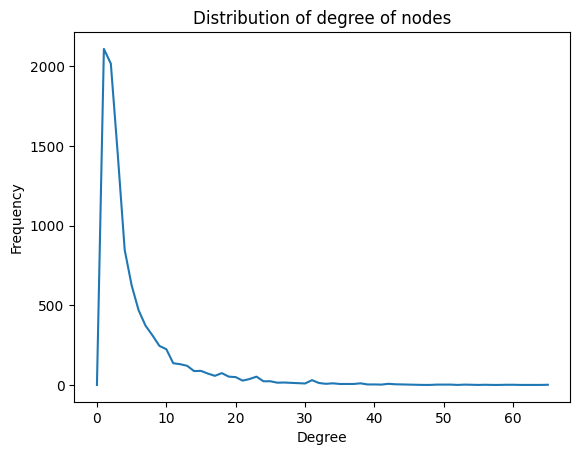

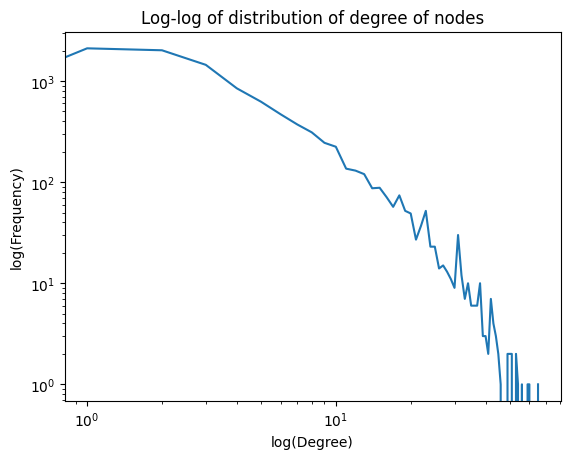

In [5]:
############## Task 4

##################
# your code here #
##################
degree_frequency = nx.degree_histogram(G)

plt.plot(degree_frequency)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Distribution of degree of nodes')
plt.show()

plt.loglog(degree_frequency)
plt.xlabel('log(Degree)')
plt.ylabel('log(Frequency)')
plt.title('Log-log of distribution of degree of nodes')
plt.show()

In [6]:
############## Task 5

##################
# your code here #
##################
print('Global clustering coefficient:', nx.transitivity(G))

Global clustering coefficient: 0.2839996525875546


## Part 2: Community detection

In [7]:
import networkx as nx
import numpy as np
from scipy.sparse.linalg import eigs
from scipy.sparse import diags, eye
from random import randint
from sklearn.cluster import KMeans

In [8]:
############## Task 6
# Perform spectral clustering to partition graph G into k clusters
def spectral_clustering(G, k):

    ##################
    # your code here #
    ##################
    A = nx.adjacency_matrix(G)      # Adjacency matrix

    I = eye(G.number_of_nodes())    # Identity matrix
    D_inv = diags([1/G.degree(node) for node in G.nodes()]) # Inverse of diagonal degree matrix
    L_rw = I - (D_inv @ A)          # Laplacian matrix

    eig_vals, eig_vecs = eigs(L_rw)
    eig_vals = eig_vals.real
    eig_vecs = eig_vecs.real
    U = eig_vecs[:, eig_vals.argsort()[:k]]

    kmeans = KMeans(n_clusters=k).fit(U)
    clusters = kmeans.predict(U)
    clustering = dict(zip(G.nodes(), clusters))

    return clustering

In [9]:
############## Task 7

##################
# your code here #
##################
largest_cc_spectral_clustering = spectral_clustering(largest_cc, 50)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [10]:
############## Task 8
# Compute modularity value from graph G based on clustering
def modularity(G, clustering):

    ##################
    # your code here #
    ##################
    unique_clusters = list(np.unique(list(clustering.values())))
    m = G.number_of_edges()         # Total number of edges in graph
    n_c = len(unique_clusters)      # Number of clusters in graph
    modularity = 0
    for c in unique_clusters:
        nodes_in_cluster = [node for node in G.nodes() if clustering[node] == c]
        l_c = G.subgraph(nodes_in_cluster).number_of_edges()            # Number of edges in cluster
        d_c = sum([d for (_,d) in list(G.degree(nodes_in_cluster))])    # Sum of degrees in G of nodes in cluster
        modularity += l_c/m - (d_c/(2*m))**2

    return modularity

In [11]:
############## Task 9

##################
# your code here #
##################
# (i)
print('Modularity of clusterings of giant connected component:')
print('- Spectral clustering:', modularity(largest_cc, largest_cc_spectral_clustering))

# (ii)
largest_cc_random_clustering = {node: randint(1,50) for node in G.nodes()}
print('- Random clustering:', modularity(largest_cc, largest_cc_random_clustering))

Modularity of clusterings of giant connected component:
- Spectral clustering: 0.0036656741949168594
- Random clustering: 0.0002462336829270765


## Part 3: Graph classification

In [12]:
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [13]:
############## Task 10
# Generate simple dataset
def create_dataset():
    Gs = list()
    y = list()

    ##################
    # your code here #
    ##################
    for n in range(3,103):
        Gs += [nx.cycle_graph(n), nx.path_graph(n)]
        y += [0,1]

    return Gs, y


Gs, y = create_dataset()
G_train, G_test, y_train, y_test = train_test_split(Gs, y, test_size=0.1)

# Compute the shortest path kernel
def shortest_path_kernel(Gs_train, Gs_test):
    all_paths = dict()
    sp_counts_train = dict()

    for i,G in enumerate(Gs_train):
        sp_lengths = dict(nx.shortest_path_length(G))
        sp_counts_train[i] = dict()
        nodes = G.nodes()
        for v1 in nodes:
            for v2 in nodes:
                if v2 in sp_lengths[v1]:
                    length = sp_lengths[v1][v2]
                    if length in sp_counts_train[i]:
                        sp_counts_train[i][length] += 1
                    else:
                        sp_counts_train[i][length] = 1

                    if length not in all_paths:
                        all_paths[length] = len(all_paths)

    sp_counts_test = dict()

    for i,G in enumerate(Gs_test):
        sp_lengths = dict(nx.shortest_path_length(G))
        sp_counts_test[i] = dict()
        nodes = G.nodes()
        for v1 in nodes:
            for v2 in nodes:
                if v2 in sp_lengths[v1]:
                    length = sp_lengths[v1][v2]
                    if length in sp_counts_test[i]:
                        sp_counts_test[i][length] += 1
                    else:
                        sp_counts_test[i][length] = 1

                    if length not in all_paths:
                        all_paths[length] = len(all_paths)

    phi_train = np.zeros((len(Gs_train), len(all_paths)))
    for i in range(len(Gs_train)):
        for length in sp_counts_train[i]:
            phi_train[i,all_paths[length]] = sp_counts_train[i][length]


    phi_test = np.zeros((len(Gs_test), len(all_paths)))
    for i in range(len(Gs_test)):
        for length in sp_counts_test[i]:
            phi_test[i,all_paths[length]] = sp_counts_test[i][length]

    K_train = np.dot(phi_train, phi_train.T)
    K_test = np.dot(phi_test, phi_train.T)

    return K_train, K_test

In [14]:
############## Task 11
# Compute the graphlet kernel
def graphlet_kernel(Gs_train, Gs_test, n_samples=200):
    graphlets = [nx.Graph(), nx.Graph(), nx.Graph(), nx.Graph()]

    graphlets[0].add_nodes_from(range(3))

    graphlets[1].add_nodes_from(range(3))
    graphlets[1].add_edge(0,1)

    graphlets[2].add_nodes_from(range(3))
    graphlets[2].add_edge(0,1)
    graphlets[2].add_edge(1,2)

    graphlets[3].add_nodes_from(range(3))
    graphlets[3].add_edge(0,1)
    graphlets[3].add_edge(1,2)
    graphlets[3].add_edge(0,2)


    phi_train = np.zeros((len(Gs_train), 4))

    ##################
    # your code here #
    ##################
    for i in range(len(Gs_train)):
        for _ in range(n_samples):
            random_graphlet = Gs_train[i].subgraph(list(np.random.choice(list(Gs_train[i].nodes()), 3)))
            for j in range(len(graphlets)):
                if nx.is_isomorphic(random_graphlet, graphlets[j]):
                    phi_train[i,j] += 1


    phi_test = np.zeros((len(Gs_test), 4))

    ##################
    # your code here #
    ##################
    for i in range(len(Gs_test)):
        for _ in range(n_samples):
            random_graphlet = Gs_test[i].subgraph(list(np.random.choice(list(Gs_test[i].nodes()), 3)))
            for j in range(len(graphlets)):
                if nx.is_isomorphic(random_graphlet, graphlets[j]):
                    phi_test[i,j] += 1


    K_train = np.dot(phi_train, phi_train.T)
    K_test = np.dot(phi_test, phi_train.T)

    return K_train, K_test


K_train_sp, K_test_sp = shortest_path_kernel(G_train, G_test)

In [15]:
############## Task 12

##################
# your code here #
##################
K_train_gl, K_test_gl = graphlet_kernel(G_train, G_test)

In [16]:
############## Task 13

##################
# your code here #
##################
clf_sp = SVC(kernel='precomputed').fit(K_train_sp, y_train)
y_pred_sp = clf_sp.predict(K_test_sp)
print('Accuracy of shortest path kernel:', accuracy_score(y_test, y_pred_sp))

clf_gl = SVC(kernel='precomputed').fit(K_train_gl, y_train)
y_pred_gl = clf_gl.predict(K_test_gl)
print('Accuracy of graphlet kernel:', accuracy_score(y_test, y_pred_gl))

Accuracy of shortest path kernel: 1.0
Accuracy of graphlet kernel: 0.4
